# Gaussian process

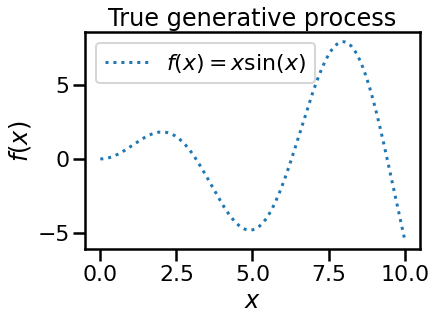

In [43]:
# %%
# Dataset generation
# ------------------
#
# We will start by generating a synthetic dataset. The true generative process
# is defined as :math:`f(x) = x \sin(x)`.
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

# %%
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [44]:
# %%
# We will use this dataset in the next experiment to illustrate how Gaussian
# Process regression is working.
#
# Example with noise-free target
# ------------------------------
#
# In this first example, we will use the true generative process without
# adding any noise. For training the Gaussian Process regression, we will only
# select few samples.
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

# %%
# Now, we fit a Gaussian process on these few training data samples. We will
# use a radial basis function (RBF) kernel and a constant parameter to fit the
# amplitude.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

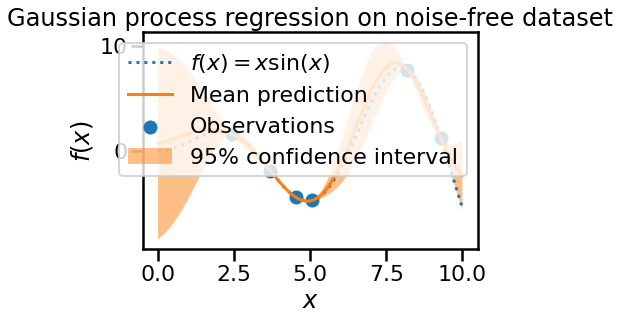

In [45]:
# %%
# After fitting our model, we see that the hyperparameters of the kernel have
# been optimized. Now, we will use our kernel to compute the mean prediction
# of the full dataset and plot the 95% confidence interval.
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [46]:
# %%
# We see that for a prediction made on a data point close to the one from the
# training set, the 95% confidence has a small amplitude. Whenever a sample
# falls far from training data, our model's prediction is less accurate and the
# model prediction is less precise (higher uncertainty).
#
# Example with noisy targets
# --------------------------
#
# We can repeat a similar experiment adding an additional noise to the target
# this time. It will allow seeing the effect of the noise on the fitted model.
#
# We add some random Gaussian noise to the target with an arbitrary
# standard deviation.
dy = 0.5 + 1.0 * rng.random_sample(y_train.shape)
y_train_noisy = y_train + rng.normal(0, dy)

In [47]:
# %%
# We create a similar Gaussian process model. In addition to the kernel, this
# time, we specify the parameter `alpha` which can be interpreted as the
# variance of a Gaussian noise.
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=dy ** 2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

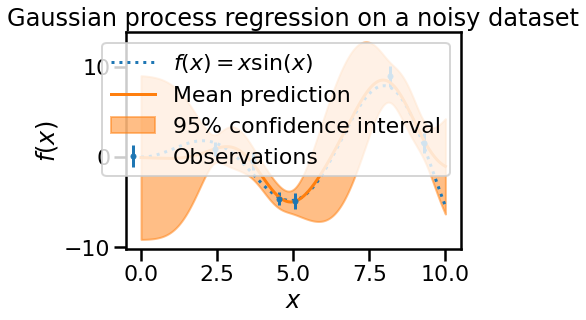

In [48]:
# %%
# Let's plot the mean prediction and the uncertainty region as before.
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    dy,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")


Gaussian Processes regression: basic introductory example

A simple one-dimensional regression example computed in two different ways:

1. A noise-free case
2. A noisy case with known noise-level per datapoint

In both cases, the kernel's parameters are estimated using the maximum
likelihood principle.

The figures illustrate the interpolating property of the Gaussian Process model
as well as its probabilistic nature in the form of a pointwise 95% confidence
interval.

Note that `alpha` is a parameter to control the strength of the Tikhonov
regularization on the assumed training points' covariance matrix.



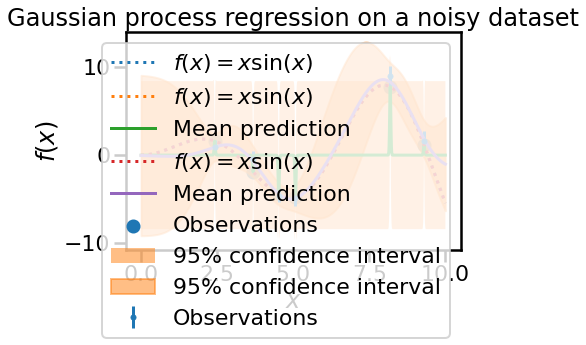

In [42]:
"""
=========================================================
Gaussian Processes regression: basic introductory example
=========================================================

A simple one-dimensional regression example computed in two different ways:

1. A noise-free case
2. A noisy case with known noise-level per datapoint

In both cases, the kernel's parameters are estimated using the maximum
likelihood principle.

The figures illustrate the interpolating property of the Gaussian Process model
as well as its probabilistic nature in the form of a pointwise 95% confidence
interval.

Note that `alpha` is a parameter to control the strength of the Tikhonov
regularization on the assumed training points' covariance matrix.
"""
print(__doc__)

# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#         Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause











# %%
# The noise affects the predictions close to the training samples: the
# predictive uncertainty near to the training samples is larger because we
# explicitly model a given level target noise independent of the input
# variable.


### Build the dataset

We will derive a dataset from the Mauna Loa Observatory that collected air
samples. We are interested in estimating the concentration of CO2 and
extrapolate it for futher year. First, we load the original dataset available
in OpenML.

In [5]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958.0,3.0,29.0,4.0,0.0,MLO,316.1
1,1958.0,4.0,5.0,6.0,0.0,MLO,317.3
2,1958.0,4.0,12.0,4.0,0.0,MLO,317.6
3,1958.0,4.0,19.0,6.0,0.0,MLO,317.5
4,1958.0,4.0,26.0,2.0,0.0,MLO,316.4


First, we process the original dataframe to create a date index and select
only the CO2 column.

In [6]:
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [7]:
co2_data.index.min(), co2_data.index.max()

(Timestamp('1958-03-29 00:00:00'), Timestamp('2001-12-29 00:00:00'))

We see that we get CO2 concentration for some days from March, 1958 to
December, 2001. We can plot these raw information to have a better
understanding.

In [16]:
import seaborn as sns
sns.set_context("poster")

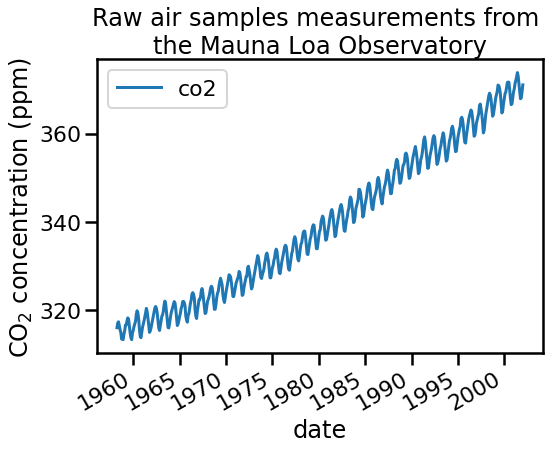

In [21]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(8, 6))
co2_data.plot(ax=ax)
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from \nthe Mauna Loa Observatory")

We will preprocess the dataset by taking a monthly average and drop month
for which no measurements were collected. Such a processing will have an
smoothing effect on the data.

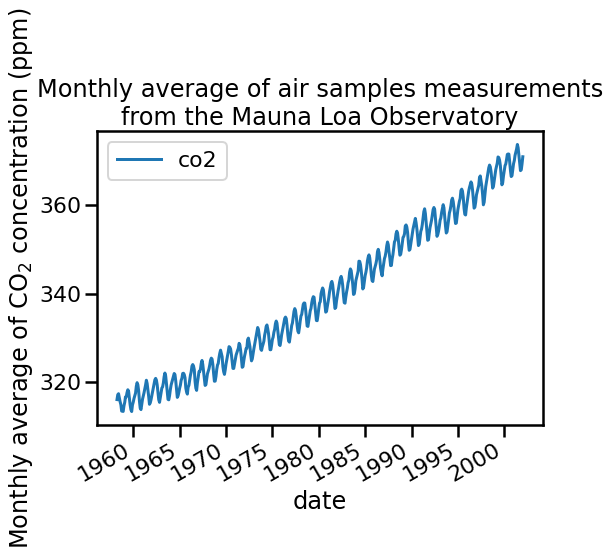

In [22]:
_, ax = plt.subplots(figsize=(8, 6))
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data.plot(ax=ax)
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\n" "from the Mauna Loa Observatory"
)

The idea in this example will be to predict the CO2 concentration in function
of the date. We are as well interested in extrapolating for upcoming year
after 2001.

As a first step, we will divide the data and the target to estimate. The data
being a date, we will convert it into a numeric.

In [23]:
X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()

### Design the proper kernel

To design the kernel to use with our Gaussian process, we can make some
assumption regarding the data at hand. We observe that they have several
characteristics: we see a long term rising trend, a pronounced seasonal
variation and some smaller irregularities. We can use different appropriate
kernel that would capture these features.

First, the long term rising trend could be fitted using a radial basis
function (RBF) kernel with a large length-scale parameter. The RBF kernel
with a large length-scale enforces this component to be smooth. An trending
increase is not enforced as to give a degree of freedom to our model. The
specific length-scale and the amplitude are free hyperparameters.

In [24]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0 ** 2 * RBF(length_scale=50.0)

The seasonal variation is explained by the periodic exponential sine squared
kernel with a fixed periodicity of 1 year. The length-scale of this periodic
component, controlling its smoothness, is a free parameter. In order to allow
decaying away from exact periodicity, the product with an RBF kernel is
taken. The length-scale of this RBF component controls the decay time and is
a further free parameter. This type of kernel is also known as locally
periodic kernel.

In [25]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0 ** 2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

The small irregularities are to be explained by a rational quadratic kernel
component, whose length-scale and alpha parameter, which quantifies the
diffuseness of the length-scales, are to be determined. A rational quadratic
kernel is equivalent to an RBF kernel with several length-scale and will
better accommodate the different irregularities.

In [26]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5 ** 2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

Finally, the noise in the dataset can be accounted with a kernel consisting
of an RBF kernel contribution, which shall explain the correlated noise
components such as local weather phenomena, and a white kernel contribution
for the white noise. The relative amplitudes and the RBF's length scale are
further free parameters.

In [27]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1 ** 2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1 ** 2, noise_level_bounds=(1e-5, 1e5)
)

In [28]:
# Thus, our final kernel is an addition of all previous kernel.
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

### Model fitting and extrapolation

Now, we are ready to use a Gaussian process regressor and fit the available
data. To follow the example from the literature, we will subtract the mean
from the target. We could have used `normalize_y=True`. However, doing so
would have also scaled the target (dividing `y` by its standard deviation).
Thus, the hyperparameters of the different kernel would have had different
meaning since they would not have been expressed in ppm.

In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: divide by zero encountered in reciprocal
  K = base ** -self.alpha


GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

Now, we will use the Gaussian process to predict on:

- training data to inspect the goodness of fit;
- future data to see the extrapolation done by the model.

Thus, we create synthetic data from 1958 to the current month. In addition,
we need to add the subtracted mean computed during training.

In [30]:
import datetime
import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

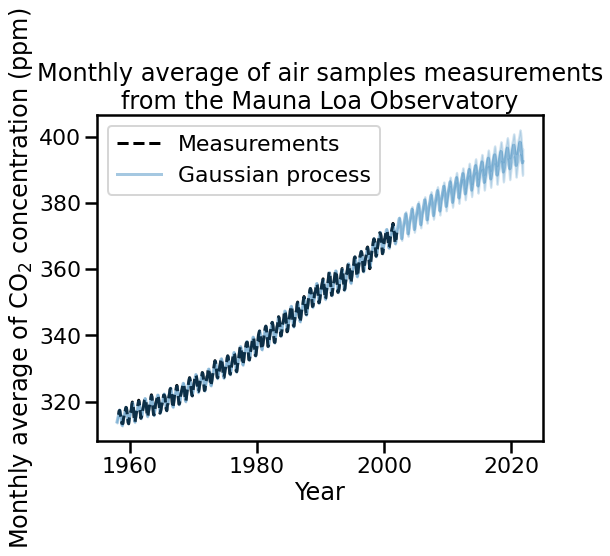

In [32]:
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(X, y, color="black", linestyle="dashed", label="Measurements")
ax.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
ax.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = ax.set_title(
    "Monthly average of air samples measurements\n" "from the Mauna Loa Observatory"
)

Our fitted model is capable to fit previous data properly and extrapolate to
future year with confidence.

### Interpretation of kernel hyperparameters

Now, we can have a look at the hyperparameters of the kernel.

In [33]:
gaussian_process.kernel_

44.8**2 * RBF(length_scale=51.6) + 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968) + 0.188**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)

Thus, most of the target signal, with the mean substracted, is explained by a
long-term rising trend for ~45 ppm and a length-scale of ~52 years. The
periodic component has an amplitude of ~2.6ppm, a decay time of ~90 years and
a length-scale of ~1.5. The long decay time indicates that we have a
component very close to a seasonal periodicity. The correlated noise has an
amplitude of ~0.2 ppm with a length scale of ~0.12 years and a white-noise
contribution of ~0.04 ppm. Thus, the overall noise level is very small,
indicating that the data can be very well explained by the model.

## Link with linear models


Comparison of kernel ridge and Gaussian process regression

This example illustrates differences between a kernel ridge regression and a
Gaussian process regression.

Both kernel ridge regression and Gaussian process regression are using a
so-called "kernel trick" to make their models expressive enough to fit
the training data. However, the machine learning problems solved by the two
methods are drastically different.

Kernel ridge regression will find the target function that minimizes a loss
function (the mean squared error).

Instead of finding a single target function, the Gaussian process regression
employs a probabilistic approach : a Gaussian posterior distribution over
target functions is defined based on the Bayes' theorem, Thus prior
probabilities on target functions are being combined with a likelihood function
defined by the observed training data to provide estimates of the posterior
distributions.

We will illustrate these differences with an example and we will also foc

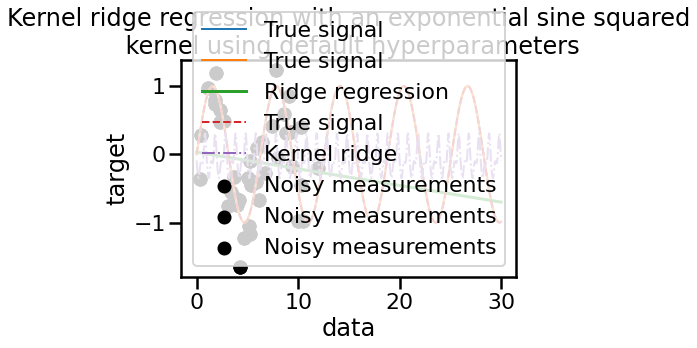

In [35]:
"""
==========================================================
Comparison of kernel ridge and Gaussian process regression
==========================================================

This example illustrates differences between a kernel ridge regression and a
Gaussian process regression.

Both kernel ridge regression and Gaussian process regression are using a
so-called "kernel trick" to make their models expressive enough to fit
the training data. However, the machine learning problems solved by the two
methods are drastically different.

Kernel ridge regression will find the target function that minimizes a loss
function (the mean squared error).

Instead of finding a single target function, the Gaussian process regression
employs a probabilistic approach : a Gaussian posterior distribution over
target functions is defined based on the Bayes' theorem, Thus prior
probabilities on target functions are being combined with a likelihood function
defined by the observed training data to provide estimates of the posterior
distributions.

We will illustrate these differences with an example and we will also focus on
tuning the kernel hyperparameters.
"""
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

# %%
# Generating a dataset
# --------------------
#
# We create a synthetic dataset. The true generative process will take a 1-D
# vector and compute its sine. Note that the period of this sine is thus
# :math:`2 \pi`. We will reuse this information later in this example.
import numpy as np

rng = np.random.RandomState(0)
data = np.linspace(0, 30, num=1_000).reshape(-1, 1)
target = np.sin(data).ravel()

# %%
# Now, we can imagine a scenario where we get observations from this true
# process. However, we will add some challenges:
#
# - the measurements will be noisy;
# - only samples from the beginning of the signal will be available.
training_sample_indices = rng.choice(np.arange(0, 400), size=40, replace=False)
training_data = data[training_sample_indices]
training_noisy_target = target[training_sample_indices] + 0.5 * rng.randn(
    len(training_sample_indices)
)

# %%
# Let's plot the true signal and the noisy measurements available for training.
import matplotlib.pyplot as plt

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training"
)

# %%
# Limitations of a simple linear model
# ------------------------------------
#
# First, we would like to highlight the limitations of a linear model given
# our dataset. We fit a :class:`~sklearn.linear_model.Ridge` and check the
# predictions of this model on our dataset.
from sklearn.linear_model import Ridge

ridge = Ridge().fit(training_data, training_noisy_target)

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(data, ridge.predict(data), label="Ridge regression")
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Limitation of a linear model such as ridge")

# %%
# Such a ridge regressor underfits data since it is not expressive enough.
#
# Kernel methods: kernel ridge and Gaussian process
# -------------------------------------------------
#
# Kernel ridge
# ............
#
# We can make the previous linear model more expressive by using a so-called
# kernel. A kernel is an embedding from the original feature space to another
# one. Simply put, it is used to map our original data into a newer and more
# complex feature space. This new space is explicitly defined by the choice of
# kernel.
#
# In our case, we know that the true generative process is a periodic function.
# We can use a :class:`~sklearn.gaussian_process.kernels.ExpSineSquared` kernel
# which allows recovering the periodicity. The class
# :class:`~sklearn.kernel_ridge.KernelRidge` will accept such a kernel.
#
# Using this model together with a kernel is equivalent to embed the data
# using the mapping function of the kernel and then apply a ridge regression.
# In practice, the data are not mapped explicitly; instead the dot product
# between samples in the higher dimensional feature space is computed using the
# "kernel trick".
#
# Thus, let's use such a :class:`~sklearn.kernel_ridge.KernelRidge`.
import time
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(kernel=ExpSineSquared())

start_time = time.time()
kernel_ridge.fit(training_data, training_noisy_target)
print(
    f"Fitting KernelRidge with default kernel: "
    f"{time.time() - start_time:.3f} seconds"
)

# %%
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    kernel_ridge.predict(data),
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using default hyperparameters"
)

In [36]:
# %%
# This fitted model is not accurate. Indeed, we did not set the parameters of
# the kernel and instead used the default ones. We can inspect them.
kernel_ridge.kernel

# %%
# Our kernel has two parameters: the length-scale and the periodicity. For our
# dataset, we use `sin` as the generative process, implying a
# :math:`2 \pi`-periodicity for the signal. The default value of the parameter
# being :math:`1`, it explains the high frequency observed in the predictions of
# our model.
# Similar conclusions could be drawn with the length-scale parameter. Thus, it
# tell us that the kernel parameters need to be tuned. We will use a randomized
# search to tune the different parameters the kernel ridge model: the `alpha`
# parameter and the kernel parameters.

# %%
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
)
start_time = time.time()
kernel_ridge_tuned.fit(training_data, training_noisy_target)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

# %%
# Fitting the model is now more computationally expensive since we have to try
# several combinations of hyperparameters. We can have a look at the
# hyperparameters found to get some intuitions.
kernel_ridge_tuned.best_params_

Time for KernelRidge fitting: 0.996 seconds


{'alpha': 1.9915849773450223,
 'kernel__length_scale': 0.7986499491396728,
 'kernel__periodicity': 6.607275806426108}

Time for KernelRidge predict: 0.003 seconds


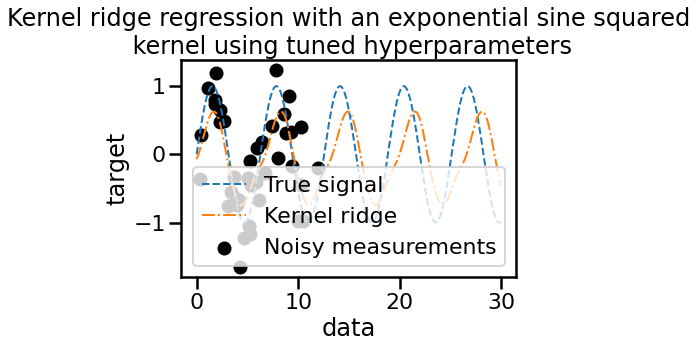

In [37]:
# %%
# Looking at the best parameters, we see that they are different from the
# defaults. We also see that the periodicity is closer to the expected value:
# :math:`2 \pi`. We can now inspect the predictions of our tuned kernel ridge.
start_time = time.time()
predictions_kr = kernel_ridge_tuned.predict(data)
print(f"Time for KernelRidge predict: {time.time() - start_time:.3f} seconds")

# %%
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters"
)

In [38]:
# %%
# We get a much more accurate model. We still observe some errors mainly due to
# the noise added to the dataset.
#
# Gaussian process regression
# ...........................
#
# Now, we will use a
# :class:`~sklearn.gaussian_process.GaussianProcessRegressor` to fit the same
# dataset. When training a Gaussian process, the hyperparameters of the kernel
# are optimized during the fitting process. There is no need for an external
# hyperparameter search. Here, we create a slightly more complex kernel than
# for the kernel ridge regressor: we add a
# :class:`~sklearn.gaussian_process.kernels.WhiteKernel` that is used to
# estimate the noise in the dataset.
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(
    1e-1
)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
start_time = time.time()
gaussian_process.fit(training_data, training_noisy_target)
print(
    f"Time for GaussianProcessRegressor fitting: "
    f"{time.time() - start_time:.3f} seconds"
)

# %%
# The computation cost of training a Gaussian process is much less than the
# kernel ridge that uses a randomized search. We can check the parameters of
# the kernels that we computed.
gaussian_process.kernel_

Time for GaussianProcessRegressor fitting: 0.036 seconds


0.675**2 * ExpSineSquared(length_scale=1.34, periodicity=6.57) + WhiteKernel(noise_level=0.182)

Time for GaussianProcessRegressor predict: 0.004 seconds


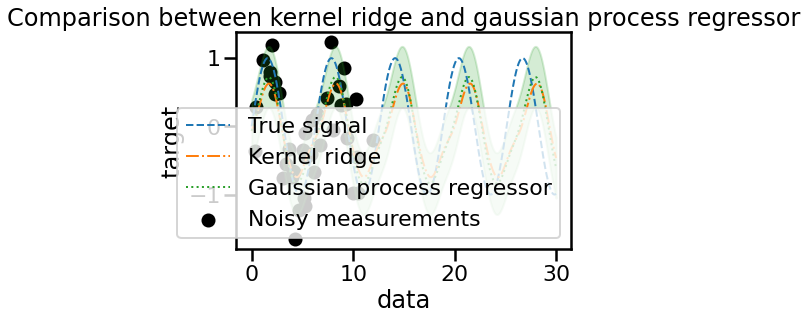

In [39]:
# %%
# Indeed, we see that the parameters have been optimized. Looking at the
# `periodicity` parameter, we see that we found a period close to the
# theoretical value :math:`2 \pi`. We can have a look now at the predictions of
# our model.
start_time = time.time()
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)
print(
    f"Time for GaussianProcessRegressor predict: "
    f"{time.time() - start_time:.3f} seconds"
)

# %%
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
# Plot the predictions of the kernel ridge
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
# Plot the predictions of the gaussian process regressor
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Comparison between kernel ridge and gaussian process regressor")

In [40]:
# %%
# We observe that the results of the kernel ridge and the Gaussian process
# regressor are close. However, the Gaussian process regressor also provide
# an uncertainty information that is not available with a kernel ridge.
# Due to the probabilistic formulation of the target functions, the
# Gaussian process can output the standard deviation (or the covariance)
# together with the mean predictions of the target functions.
#
# However, it comes at a cost: the time to compute the predictions is higher
# with a Gaussian process.
#
# Final conclusion
# ----------------
#
# We can give a final word regarding the possibility of the two models to
# extrapolate. Indeed, we only provided the beginning of the signal as a
# training set. Using a periodic kernel forces our model to repeat the pattern
# found on the training set. Using this kernel information together with the
# capacity of the both models to extrapolate, we observe that the models will
# continue to predict the sine pattern.
#
# Gaussian process allows to combine kernels together. Thus, we could associate
# the exponential sine squared kernel together with a radial basis function
# kernel.
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) * RBF(
    length_scale=15, length_scale_bounds="fixed"
) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(training_data, training_noisy_target)
mean_predictions_gpr, std_predictions_gpr = gaussian_process.predict(
    data,
    return_std=True,
)

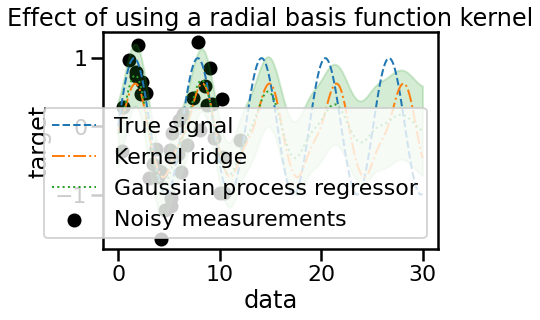

In [41]:
# %%
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
# Plot the predictions of the kernel ridge
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
# Plot the predictions of the gaussian process regressor
plt.plot(
    data,
    mean_predictions_gpr,
    label="Gaussian process regressor",
    linewidth=2,
    linestyle="dotted",
)
plt.fill_between(
    data.ravel(),
    mean_predictions_gpr - std_predictions_gpr,
    mean_predictions_gpr + std_predictions_gpr,
    color="tab:green",
    alpha=0.2,
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Effect of using a radial basis function kernel")

# %%
# The effect of using a radial basis function kernel will attenuate the
# periodicity effect once that no sample are available in the training.
# As testing samples get further away from the training ones, predictions
# are converging towards their mean and their standard deviation
# also increases.